# Recreating https://arxiv.org/pdf/1608.02609.pdf first for $\rho$-$\rho$ decays

## Inputs:
- Invariant masses of intermediate resonances  
- Acoplanarity angles
- Variables $y_i^+$ ($y_k^-$)
- 4 momentum of visible decay products
- 4 momentum of intermediate resonances
    - If cascade decays, need to provide 4-momenta of all $\pi^+\pi^-$ pairs which can form the resonances
- Need to boost all four vectors where primary resonances are aligned along the z-axis.
- Normalise all features

In [335]:
import uproot 
import numpy as np
import math
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score

from pylorentz import Momentum4
from pylorentz import Position4
from lbn_modified import LBN, LBNLayer
from ROOT import TLorentzVector, TVector3

In [336]:
tree_tt = uproot.open("/eos/user/k/kgalambo/SWAN_projects/Masters_CP_Kristof_2/MVAFILE_AllHiggs_tt.root")["ntuple"]

variables = [
            "wt_cp_sm", "wt_cp_ps", "wt_cp_mm", "rand",
            "aco_angle_1", 
            "mva_dm_1","mva_dm_2",
            "tau_decay_mode_1","tau_decay_mode_2",
        #     "ip_x_1", "ip_y_1", "ip_z_1", "ip_x_2", "ip_y_2", "ip_z_2", # ignore impact parameter for now
            "pi_E_1", "pi_px_1", "pi_py_1", "pi_pz_1", 
            "pi_E_2", "pi_px_2", "pi_py_2", "pi_pz_2", 
            "pi0_E_1", "pi0_px_1", "pi0_py_1", "pi0_pz_1",
            "pi0_E_2", "pi0_px_2", "pi0_py_2", "pi0_pz_2", 
            "y_1_1", "y_1_2"
        ]

In [337]:
# this line takes a long time!
df = tree_tt.pandas.df(variables)

In [338]:
# select only rho-rho events
df = df[(df['mva_dm_1']==1) & (df['mva_dm_2']==1) & (df["tau_decay_mode_1"] == 1) & (df["tau_decay_mode_2"] == 1)]

# create labels y
y = (~(df["rand"]<df["wt_cp_ps"]/2).to_numpy()).astype(int)

# drop unnecessary labels 
df = df.drop(["mva_dm_1","mva_dm_2","tau_decay_mode_1","tau_decay_mode_2", "wt_cp_sm", "wt_cp_ps", "wt_cp_mm", "rand"], axis=1).reset_index(drop=True)

In [339]:
df.head()

,aco_angle_1,pi_E_1,pi_px_1,pi_py_1,pi_pz_1,pi_E_2,pi_px_2,pi_py_2,pi_pz_2,pi0_E_1,pi0_px_1,pi0_py_1,pi0_pz_1,pi0_E_2,pi0_px_2,pi0_py_2,pi0_pz_2,y_1_1,y_1_2
0,2.657029,45.423448,-13.747046,-38.825621,-19.153590,35.805782,8.526798,34.653880,2.904638,10.039846,-3.551914,-8.385803,-4.224041,6.112238,1.959179,5.735656,0.777900,-0.637964,-0.708372
1,1.547246,24.506373,-14.056253,9.809321,-17.514046,19.587723,8.539313,-3.149378,-17.344192,41.244844,-24.443820,15.370633,-29.451014,77.036002,32.655902,-12.032904,-68.726477,0.254573,0.594557
2,3.750274,15.319610,8.794122,0.774085,12.519393,17.469988,-9.876231,-3.253855,14.037575,69.457213,38.899682,2.503120,57.487698,56.810782,-32.919951,-10.831700,45.015529,0.638590,0.529623
3,1.192612,94.211361,42.942276,-33.711103,-76.780750,3.656937,-2.129749,0.251363,-2.958835,25.585962,11.770386,-8.993712,-20.861314,68.839211,-41.770362,4.326843,-54.546623,-0.572846,0.899114
4,3.264792,25.899289,-22.245884,-12.141924,-5.333670,23.795390,21.402816,9.436143,-4.368043,23.216735,-20.268636,-10.296444,-4.707891,18.242053,16.607666,6.693405,-3.483969,-0.054617,-0.132105


- [x] calculate 4 momentum of resonances
- [x] calculate invariant mass of resonances m^2 = E^2 - p^2
- [ ] cascades?

In [340]:
# parse particle information
#columns = ['E', 'px', 'py', 'pz']

pi_1 = df[['pi_E_1', "pi_px_1", "pi_py_1", "pi_pz_1"]].to_numpy()
pi_2 = df[['pi_E_2', "pi_px_2", "pi_py_2", "pi_pz_2"]].to_numpy()
pi0_1 = df[['pi0_E_1', "pi0_px_1", "pi0_py_1", "pi0_pz_1"]].to_numpy()
pi0_2 = df[['pi0_E_2', "pi0_px_2", "pi0_py_2", "pi0_pz_2"]].to_numpy()

In [341]:
# reconstruct resonance 4 momentum
rho_1 = pi_1 + pi0_1
rho_2 = pi_2 + pi0_2

In [342]:
# calculate invariate masses
rho_1_m = (rho_1[:, 0]**2 - rho_1[:, 1]**2 - rho_1[:, 2]**2 - rho_1[:, 3]**2)**0.5
rho_2_m = (rho_2[:, 0]**2 - rho_2[:, 1]**2 - rho_2[:, 2]**2 - rho_2[:, 3]**2)**0.5

In [343]:
p3 = Momentum4(pi_1[:, 0], pi_1[:, 1], pi_1[:, 2], pi_1[:, 3])
p4 = Momentum4(pi_2[:, 0], pi_2[:, 1], pi_2[:, 2], pi_2[:, 3])
p1 = Momentum4(pi0_1[:, 0], pi0_1[:, 1], pi0_1[:, 2], pi0_1[:, 3])
p2 = Momentum4(pi0_2[:, 0], pi0_2[:, 1], pi0_2[:, 2], pi0_2[:, 3])
r1 = p1 + p3
r2 = p2 + p4

In [344]:
p1_boosted = p1.boost_particle(-r1)
p3_boosted = p3.boost_particle(-r1)
p2_boosted = p2.boost_particle(-r2)
p4_boosted = p4.boost_particle(-r2)
r1_boosted = p1_boosted + p3_boosted
r2_boosted = p2_boosted + p4_boosted

## Rotations

The rotations are done as follows:

- calculate unit vectors along the 3-momenta

- calculate the axes which are perpendicular to the z-axis and the unit vectors

- rotate the 3-momenta about these axes by the angle between the z-axis and the unit vectors

In [345]:
#unit vectors along the momenta of the primary resonances
unit1 = (r1_boosted[1:, :] / np.linalg.norm(r1_boosted[1:, :], axis=0)).transpose()
unit2 = (r2_boosted[1:, :] / np.linalg.norm(r2_boosted[1:, :], axis=0)).transpose()

/usr/local/bin/start_ipykernel.py:2: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/bin/start_ipykernel.py:3: RuntimeWarning: invalid value encountered in true_divide
  import sys


In [346]:
# probably there's a faster way of doing this
zaxis = np.array([np.array([0., 0., 1.]) for _ in range(len(unit1))])

In [347]:
axes1 = np.cross(unit1, zaxis)
axes2 = np.cross(unit2, zaxis)

In [348]:
dotproduct1 = (unit1*zaxis).sum(1)
angles1 = np.arccos(dotproduct1)
dotproduct2 = (unit2*zaxis).sum(1)
angles2 = np.arccos(dotproduct2)

In [349]:
def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / math.sqrt(np.dot(axis, axis))
    a = math.cos(theta / 2.0)
    b, c, d = -axis * math.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

def rotate(vect, axis, theta):
    return np.dot(rotation_matrix(axis, theta), vect)

test_vector = [1, 0, 0]
test_axis = [0, 1, 0]
test_angle = np.pi/2

print('The rotated test_vector is:')
print(rotate(test_vector, test_axis, test_angle))

The rotated test_vector is:
[ 2.22044605e-16  0.00000000e+00 -1.00000000e+00]


In [350]:
# it would be nice to be able to do the rotation in a vectorized form, like this:
#p1rot = rotate(p1_boosted[1:, :].transpose(), axes1, angles1)

p1rot = []
p2rot = []
p3rot = []
p4rot = []
for i in range(p1_boosted[:].shape[1]):
    p1rot.append(rotate(p1_boosted[1:, i], axes1[i], angles1[i]))
    p2rot.append(rotate(p2_boosted[1:, i], axes1[i], angles1[i]))
    p3rot.append(rotate(p3_boosted[1:, i], axes1[i], angles1[i]))
    p4rot.append(rotate(p4_boosted[1:, i], axes1[i], angles1[i]))
    if i%100000==0:
        print('finished rotating 3-vector', i)
p1rot = np.array(p1rot)
p2rot = np.array(p2rot)
p3rot = np.array(p3rot)
p4rot = np.array(p4rot)

finished rotating 3-vector 0


/usr/local/bin/start_ipykernel.py:7: RuntimeWarning: invalid value encountered in true_divide


finished rotating 3-vector 100000
finished rotating 3-vector 200000
finished rotating 3-vector 300000
finished rotating 3-vector 400000
finished rotating 3-vector 500000
finished rotating 3-vector 600000


In [351]:
# this should be vectorized as well
p1_rotated = []
p2_rotated = []
p3_rotated = []
p4_rotated = []
for i in range(p1_boosted[:].shape[1]):
    p1_rotated.append([p1_boosted[0, i], p1rot[i, 0], p1rot[i, 1], p1rot[i, 2]])
    p2_rotated.append([p2_boosted[0, i], p2rot[i, 0], p2rot[i, 1], p2rot[i, 2]])
    p3_rotated.append([p3_boosted[0, i], p3rot[i, 0], p3rot[i, 1], p3rot[i, 2]])
    p4_rotated.append([p4_boosted[0, i], p4rot[i, 0], p4rot[i, 1], p4rot[i, 2]])
    if i%100000==0:
        print('finished getting rotated 4-vector', i)
p1_rotated = np.array(p1_rotated).transpose()
p2_rotated = np.array(p2_rotated).transpose()
p3_rotated = np.array(p3_rotated).transpose()
p4_rotated = np.array(p4_rotated).transpose()

finished getting rotated 4-vector 0
finished getting rotated 4-vector 100000
finished getting rotated 4-vector 200000
finished getting rotated 4-vector 300000
finished getting rotated 4-vector 400000
finished getting rotated 4-vector 500000
finished getting rotated 4-vector 600000


## The neural net

The inputs of these neural nets are the following:

- aco_angle_1

- y_1_1 and y_1_2

- the primary resonance masses

- the unrotated, or the rotated 4-vectors, or no 4-vectors at all

In [352]:
# create features and labels

aco_angle_1 = df['aco_angle_1'].to_numpy()
y_1_1 = df['y_1_1'].to_numpy()
y_1_2 = df['y_1_2'].to_numpy()

# this will use the unrotated, boosted 4-vectors:
E1 = p1_boosted[0]
px1 = p1_boosted[1]
py1 = p1_boosted[2]
pz1 = p1_boosted[3]
E2 = p2_boosted[0]
px2 = p2_boosted[1]
py2 = p2_boosted[2]
pz2 = p2_boosted[3]
E3 = p3_boosted[0]
px3 = p3_boosted[1]
py3 = p3_boosted[2]
pz3 = p3_boosted[3]
E4 = p4_boosted[0]
px4 = p4_boosted[1]
py4 = p4_boosted[2]
pz4 = p4_boosted[3]

# this will use the rotated, boosted 4-vectors:
E1r = p1_rotated[0]
px1r = p1_rotated[1]
py1r = p1_rotated[2]
pz1r = p1_rotated[3]
E2r = p2_rotated[0]
px2r = p2_rotated[1]
py2r = p2_rotated[2]
pz2r = p2_rotated[3]
E3r = p3_rotated[0]
px3r = p3_rotated[1]
py3r = p3_rotated[2]
pz3r = p3_rotated[3]
E4r = p4_rotated[0]
px4r = p4_rotated[1]
py4r = p4_rotated[2]
pz4r = p4_rotated[3]

# if it gives the same accuracy score with the 4-vectors and without them, that's bad
# with the unrotated 4-vectors:
X = np.stack([rho_1_m, rho_2_m, E1, px1, py1, pz1, E2, px2, py2, pz2, E3, px3, py3, pz3, E4, px4, py4, pz4, aco_angle_1, y_1_1, y_1_2], axis=1)
## with the rotated 4-vectors:
#X = np.stack([rho_1_m, rho_2_m, E1r, px1r, py1r, pz1r, E2r, px2r, py2r, pz2r, E3r, px3r, py3r, pz3r, E4r, px4r, py4r, pz4r, aco_angle_1, y_1_1, y_1_2], axis=1)
## without the 4-vectors:
#X = np.stack([rho_1_m, rho_2_m, aco_angle_1, y_1_1, y_1_2], axis=1)

# y is defined earlier

In [353]:
## for some reason there are about 30,000 nan values in X
#print(np.argwhere(np.isnan(X)))

In [354]:
## will debug this tomorrow
## this would remove the nans from the feature and the label set
#nan_mask = np.isnan(X)
#nan_mask_y = np.array([x.any() for x in nan_mask])
#print(nan_mask_y.shape)
#print(y.shape)
#print(X.shape)
#X = X[~nan_mask]
#y = y[~nan_mask_y]
#print(X.shape)

In [355]:
print(y.shape)
print(X.shape)
print('The number of samples should be the same in X and y!')

(653528,)
(653528, 21)
The number of samples should be the same in X and y!


In [356]:
# split X and y into train and validation dataset 

X_train,X_test, y_train, y_test  = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=123456,
    #stratify=y.values,
)

In [357]:
# define a simple NN
def baseline_model():
    # create model
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(38, input_dim=X.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(tf.keras.layers.Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    model.compile(loss='binary_crossentropy', optimizer='adam')  
    return model

In [358]:
# define early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)

In [359]:
# first run the training for simple case with just 1 variable
history = tf.keras.callbacks.History()

model = baseline_model()

model.fit(
                X_train, y_train,
                batch_size=10000,
                epochs=100,
                callbacks=[history,early_stop],
                validation_data=(X_test, y_test))

W1101 22:33:06.943224 139675203118912 ag_logging.py:146] AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7f07702b0b00> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
50/53 [===========================>..] - ETA: 0s - loss: 0.6889

W1101 22:33:09.117902 139675203118912 ag_logging.py:146] AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f07900e1710> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
53/53 [==============================] - 2s 32ms/step - loss: 0.6887 - val_loss: 0.6840
Epoch 2/100
53/53 [==============================] - 1s 28ms/step - loss: 0.6835 - val_loss: 0.6822
Epoch 3/100
53/53 [==============================] - 2s 32ms/step - loss: 0.6818 - val_loss: 0.6804
Epoch 4/100
53/53 [==============================] - 2s 30ms/step - loss: 0.6799 - val_loss: 0.6786
Epoch 5/100
53/53 [==============================] - 2s 32ms/step - loss: 0.6784 - val_loss: 0.6776
Epoch 6/100
53/53 [==============================] - 2s 30ms/step - loss: 0.6776 - val_loss: 0.6769
Epoch 7/100
53/53 [==============================] - 2s 32ms/step - loss: 0.6769 - val_loss: 0.6761
E

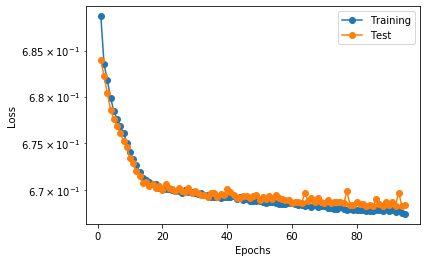

In [360]:
# Extract number of run epochs from the training history
epochs = range(1, len(history.history["loss"])+1)

# Extract loss on training and validation ddataset and plot them together
plt.plot(epochs, history.history["loss"], "o-", label="Training")
plt.plot(epochs, history.history["val_loss"], "o-", label="Test")
plt.xlabel("Epochs"), plt.ylabel("Loss")
plt.yscale("log")
plt.legend()

In [361]:
prediction = model.predict(X_test)

W1101 22:35:34.598756 139675203118912 ag_logging.py:146] AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x7f0654fa9950> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [362]:
y_pred = [int(round(x)) for x in prediction.flatten()]

In [363]:
print('The accuracy score is: {:.4f}'.format(accuracy_score(y_test, y_pred)))

The accuracy score is: 0.5901


In [364]:
#  define a function to plot the ROC curves - just makes the roc_curve look nicer than the default
def plot_roc_curve(fpr, tpr, auc):
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr)
    ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    ax.grid()
    ax.text(0.6, 0.3, 'ROC AUC Score: {:.3f}'.format(auc),
            bbox=dict(boxstyle='square,pad=0.3', fc='white', ec='k'))
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
    ax.plot(lims, lims, 'k--')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    plt.savefig('roc_rho_rho_NN_paper')

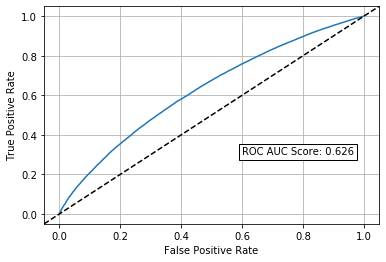

In [365]:
# plot ROC curve for improved training
y_proba = model.predict_proba(X_test) # outputs two probabilties
auc = roc_auc_score(y_test, y_proba)
fpr, tpr, _ = roc_curve(y_test, y_proba)
plot_roc_curve(fpr, tpr, auc)

## Results of the NN:

Without the 4-vectors, without the masses, after 100 epochs: accuracy score = 0.593, ROC AUC score = 0.626

Without the 4-vectors, with the masses, after 100 epochs: accuracy score = 0.593, ROC AUC score = 0.628

With the 4-vectors, without the masses, after 100 epochs, before the rotations: accuracy score = 0.593, ROC AUC score = 0.628

With the 4-vectors, with the masses, after 100 epochs, before the rotations: accuracy score = 0.590, ROC AUC score = 0.626

After the rotations: no results. Hasn't been debugged yet.